**Triangulacja Delaunay’a** chmury punktów 2D z wykorzystaniem algorytmu
iteracyjnego – analiza metod znajdowania trójkąta, do którego trafia punkt
Należy zaimplementować iteracyjny algorytm konstrukcji triangulacji Delaunay’a dla chmury
punktów w 2D omawiany na wykładzie. Należy zaimplementować co najmniej dwie różne
metody wyszukiwania trójkąta, do którego trafia nowo wprowadzany punkt. Program
powinien pozwolić na wizualizację działania programu. Przeprowadzić analizę efektywności
dla dużych zbiorów punktów wraz z porównaniem efektywności poszczególnych etapów
algorytmu. Porównać także oba warianty metody wyszukiwania trójkąta.


[WIKIPEDIA](https://en.wikipedia.org/wiki/Delaunay_triangulation)

In [ ]:
#importy
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from random import randint

In [ ]:
#globalny epsilon
EPS = 0

In [ ]:
#TODO:  napisanie det4 do is_in_circumcircle
#       Walking search
#       wprowadzanie punków z myszki (mogę wrzucić swój kod później)
#       Testy

In [ ]:

class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def distance(self, other):
    return ((self.x - other.x)**2 + (self.y - other.y)**2)

  def subtract(self, other):
    return Point(self.x - other.x, self.y - other.y)

  def __eq__(self, other):
    return self.distance(other) <= EPS

  def __hash__(self):
    return hash((round(self.x,5),round(self.x,5)))

  def __repr__(self):
    return f"({self.x}, {self.y})"


In [ ]:
class Edge:
  def __init__(self, p1, p2):
    self.p1 = p1
    self.p2 = p2

  def __eq__(self, other):
    if not isinstance(other, Edge):
            return False
    return (self.p1 == other.p1 and self.p2 == other.p2 or self.p1==other.p2 and self.p2==other.p1)
  def __hash__(self):
    s = hash(self.p1)
    b = hash(self.p2)
    return hash((min(s,b),max(s,b)))

  def __repr__(self):
    return f"Edge({self.p1}, {self.p2})"

In [ ]:

def orient(a,b,c):
    return (b.x-a.x)*(c.y-a.y)-(c.x-a.x)*(b.y-a.y)
#CCW > 0
class Triangle:
  def __init__(self, p1, p2, p3):
    if orient(p1,p2,p3) < 0:
      self.p1 = p1
      self.p2 = p3
      self.p3 = p2
    else:
      self.p1 = p1
      self.p2 = p2
      self.p3 = p3
    self.edges = [Edge(self.p1, self.p2), Edge(self.p2, self.p3), Edge(self.p3, self.p1)]
    self.neighbours = [None,None,None]
    self.is_bad = False
  def is_inside(self, p):
    return (    orient(self.p1, self.p2, p) >=0
            and orient(self.p2, self.p3, p) >=0
            and orient(self.p3, self.p1, p) >=0)
  def is_in_circumcircle(self,p):
    ax,ay = self.p1.x, self.p1.y
    bx,by = self.p2.x, self.p2.y
    cx,cy = self.p3.x, self.p3.y
    dx,dy = p.x, p.y
    det = np.linalg.det([ [ax,ay,ax**2+ay**2,1],
                          [bx,by,bx**2+by**2,1],
                          [cx,cy,cx**2+cy**2,1],
                          [dx,dy,dx**2+dy**2,1]])
    return  det>EPS

  def __repr__(self):
    return f"Triangle({self.p1}, {self.p2}, {self.p3})"

  def __eq__(self, other):
      if not isinstance(other, Triangle):
          return False
      vertices_self = {self.p1, self.p2, self.p3}
      vertices_other = {other.p1, other.p2, other.p3}
      return vertices_self == vertices_other

  def __hash__(self):
      return hash(self.p1) ^ hash(self.p2) ^ hash(self.p3)


In [ ]:
def SuperTriangle(cloud):
  """
  cloud to chmura punktów [Point(x1,y1),Point(x2,y2)...]
  """
  maxX = -float('inf')
  minX = float('inf')
  maxY = -float('inf')
  minY = float('inf')
  for p in cloud:
    x = p.x
    y = p.y
    if x > maxX:
      maxX = x
    if x < minX:
      minX = x
    if y > maxY:
      maxY = y
    if y < minY:
      minY = y

  dx = maxX - minX
  dy = maxY - minY
  delta = max(dx, dy)
  if delta == 0: delta = 1

  p1 = Point((minX + maxX) / 2, maxY + 20 * delta)
  p2 = Point(minX - 20 * delta, minY - delta)
  p3 = Point(maxX + 20 * delta, minY - delta)

  return Triangle(p1, p2, p3)

In [ ]:
def delulu(points):
    # 1. Inicjalizacja
    triangulation = set()
    super=SuperTriangle(points)
    triangulation.add(super)

    for p in points:
        removed = set()
        visited = set()  # Visited musi być czyszczone dla każdego punktu!

        # --- POPRAWKA 1: PRAWIDŁOWY DFS ---
        def dfs(t):
            visited.add(t)
            if t.is_in_circumcircle(p):
                removed.add(t)
                # Sprawdzamy sąsiadów
                for n in t.neighbours:
                    if n is not None and n not in visited:
                        dfs(n) # USUNIĘTO 'return', teraz sprawdzi wszystkich sąsiadów

        # Znajdź trójkąt startowy i uruchom DFS
        for t in triangulation:
            if t.is_inside(p):
                dfs(t)
                break

        # --- POPRAWKA 2: ZNAJDOWANIE KRAWĘDZI WRAZ Z SĄSIADAMI ---
        # Zamiast 'edges = set()' (XOR), używamy mapy: Krawędź -> Stary Sąsiad
        boundary = {}

        for t in removed:
            for i, edge in enumerate(t.edges):
                neighbor = t.neighbours[i]

                # Jeśli sąsiada nie ma w 'removed', to jest to krawędź graniczna
                if neighbor not in removed:
                    boundary[edge] = neighbor

        # Usuwamy złe trójkąty
        for t in removed:
            triangulation.remove(t)

        # --- TWORZENIE NOWYCH I ŁĄCZENIE SĄSIADÓW ---
        new_triangles = [] # Lista nowych trójkątów w tym kroku

        for edge, outer_neighbor in boundary.items():
            newT = Triangle(edge.p1, edge.p2, p)
            new_triangles.append(newT)
            triangulation.add(newT)

            # 1. Połącz z ZEWNĘTRZNYM (starym) sąsiadem
            # Szukamy krawędzi 'edge' w nowym trójkącie (zazwyczaj indeks 0)
            for i, e_new in enumerate(newT.edges):
                if e_new == edge:
                    newT.neighbours[i] = outer_neighbor

                    # Ważne: Stary sąsiad też musi wskazywać na nowy trójkąt!
                    if outer_neighbor:
                        for j, e_old in enumerate(outer_neighbor.edges):
                            if e_old == edge:
                                outer_neighbor.neighbours[j] = newT
                                break
                    break

        # 2. Połącz NOWE trójkąty między sobą (Twoje 'ns' - poprawione)
        # Używamy mapy do sklejenia boków wychodzących z punktu P
        shared_edges = {}
        for t in new_triangles:
            for i, e in enumerate(t.edges):
                # Jeśli to krawędź graniczna (nie dotyka P), pomijamy
                if e in boundary: continue

                if e in shared_edges:
                    other = shared_edges[e]
                    # Łączymy t i other
                    t.neighbours[i] = other
                    # Musimy znaleźć indeks w 'other'
                    for j, e_other in enumerate(other.edges):
                        if e_other == e:
                            other.neighbours[j] = t
                            break
                else:
                    shared_edges[e] = t
    superPs = set([super.p1,super.p2,super.p3])
    toRemove=set([])
    for t in triangulation:
        if t.p1 in superPs or t.p2 in superPs or t.p3 in superPs:
          toRemove.add(t)
    return triangulation.difference(toRemove)

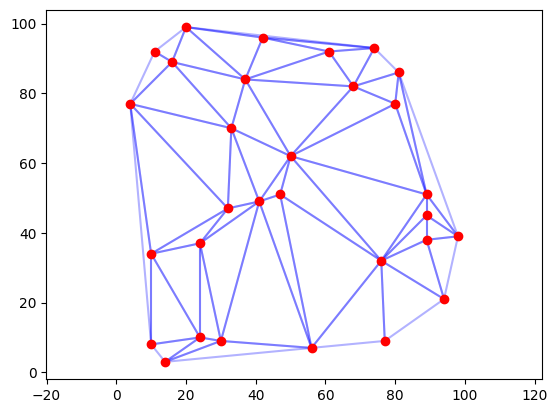

In [ ]:
# Generowanie punktów
points = [Point(randint(1,100), randint(1,100)) for _ in range(30)]

# Uruchomienie algorytmu
triangulation = delulu(points)

# --- RYSOWANIE ---

# 1. Rysowanie punktów (czerwone kropki)
# Zbieramy wszystkie X i wszystkie Y do osobnych list
px = [p.x for p in points]
py = [p.y for p in points]
plt.scatter(px, py, color='red', zorder=10) # zorder=10 żeby kropki były na wierzchu

# 2. Rysowanie krawędzi (niebieskie linie)
for t in triangulation:
    # Opcjonalnie: pomijamy rysowanie trójkątów podłączonych do SuperTriangle,
    # jeśli jeszcze nie zaimplementowałeś ich usuwania w funkcji delulu.
    # Ale nawet jeśli je narysujemy, ograniczymy widok (xlim/ylim) poniżej.

    for e in t.edges:
        # plt.plot wymaga: [x_poczatek, x_koniec], [y_poczatek, y_koniec]
        x_values = [e.p1.x, e.p2.x]
        y_values = [e.p1.y, e.p2.y]
        plt.plot(x_values, y_values, 'b-', alpha=0.3) # 'b-' = blue line, alpha = przezroczystość

# 3. Ustawienia wykresu
plt.axis('equal') # Żeby kwadraty nie były prostokątami

# WAŻNE: Ograniczamy widok tylko do naszych punktów (plus margines 5 jednostek).
# Inaczej SuperTriangle "rozsadzi" skalę wykresu.
plt.xlim(min(px) - 5, max(px) + 5)
plt.ylim(min(py) - 5, max(py) + 5)

plt.show()